In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Numpy Array를 입력값으로 받음
def z_score_outlier(ar):
    threshold = 3

    # 평균 가져오기
    mean = np.mean(ar)
    std = np.std(ar)

    # ar의 요소를 y에 하나씩 대입하고 앞에 수식을 적용해서 결과를 가지고 다시 list를 만드는 것
    z_scores = [(y-mean) / std for y in ar]

    return np.where(np.abs(z_scores) > threshold)

In [115]:
# pandas Dataframe(Series)를 입력값으로 받음
def z_score_outlier_pd(df):
    threshold = 3.5

    mean = df.mean()
    std = df.std()

    z_scores = (df-mean) / std

    plt.figure(figsize=(15, 7))
    plt.scatter(range(len(df)), df, color="g")
    plt.scatter(range(len(df)), z_scores, color="b")

    ret_df = pd.DataFrame(columns=['i', 'z-score'])

    for (i, z_score) in enumerate(z_scores):
        if np.abs(z_score) > threshold:
            ret_df = ret_df.append({"i": i, "z-score": z_score}, ignore_index=True)

    ret_df = ret_df.astype({"i": "int"})
    plt.scatter(ret_df["i"], ret_df["z-score"], color='r')
    return ret_df

In [4]:
waterlevel = pd.read_csv("./dataset/WaterLevel.csv")
waterlevel.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
waterlevel.columns

Index(['수산대교(창원)_수위', '여의리(의령군)_수위', '의령군(정암교)_수위', '함안군(서출리)_수위',
       '합천군(적포교)_수위', 'date', 'time'],
      dtype='object')

In [73]:
outlier_df = {}
# outlier_df["susan"] = z_score_outlier_pd(waterlevel['수산대교(창원)_수위'])
# outlier_df["yeo"] = z_score_outlier_pd(waterlevel['여의리(의령군)_수위'])
# outlier_df['ryeong'] = z_score_outlier_pd(waterlevel['의령군(정암교)_수위'])
# outlier_df['hapcheon'] = z_score_outlier_pd(waterlevel['합천군(적포교)_수위'])

In [128]:
Target_df = pd.read_csv("./dataset/Target_discharge.csv", low_memory=False)
Target = Target_df['총유입량']

In [65]:
Target

0        2012.950
1        1985.586
2        1929.865
3        1928.188
4        1927.172
           ...   
81930       0.000
81931      53.446
81932     110.182
81933      54.676
81934      54.716
Name: 총유입량, Length: 81935, dtype: float64

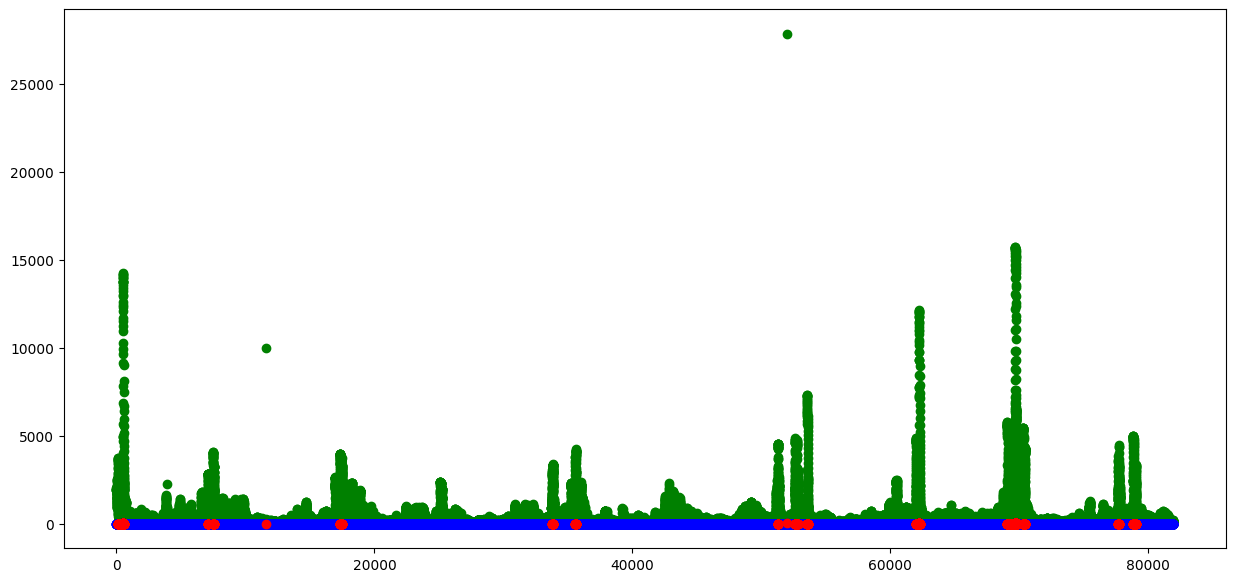

In [129]:
outlier_df['target'] = z_score_outlier_pd(Target)

# green = value
# blue = z-score
# red = outlier
# 바로 다음 라인의 그래프가 잘 찍히는 걸로 봐서는, value와 z-score의 단위 차이가 커서 이렇게 찍힌거같다.

# of Outliers in inflow:  963


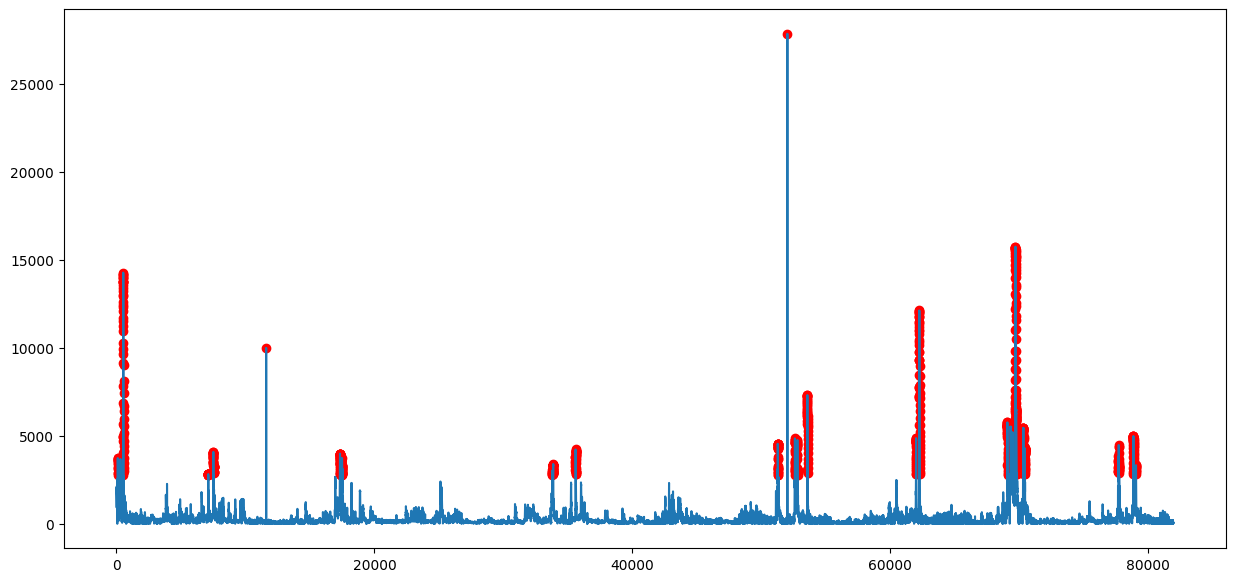

In [130]:
# 유입량 이상치 시각화
print("# of Outliers in inflow: ", len(outlier_df["target"]))
plt.figure(figsize=(15,7))
plt.plot(range(len(Target)), Target)
outlier = Target.iloc[outlier_df['target']['i']]
plt.scatter(outlier_df['target']["i"], outlier, color='r')

# 강수량과 관계 없는 이상치로 보이는 것은 두 개 정도의 점이다.
# 창녕,함안의 강수량과 유입량이 모두 이상치라면 그 때는 인정하는걸로 하자.

# 강수량 + 유입량(수위) 그래프

In [8]:
# 창녕함안보 강수량
rainfall = pd.read_csv("./dataset/RainFall.csv")

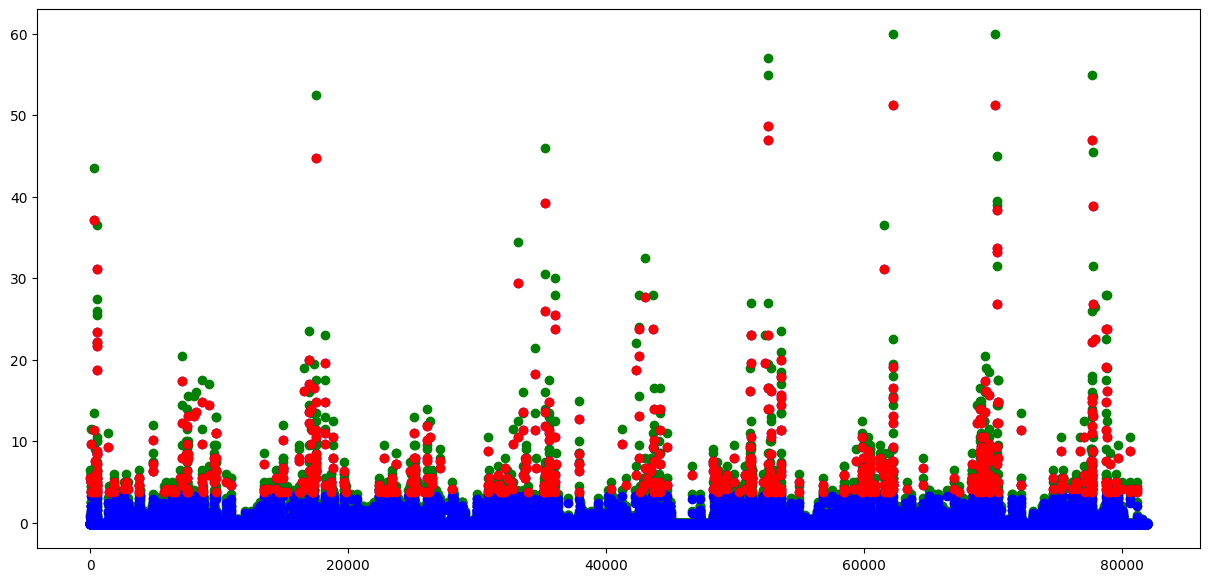

In [121]:
outlier_df["haman"] = z_score_outlier_pd(rainfall["함안강수량"])
# 초록 = 원래 강수량
# 파랑 = z-score
# 빨강 = outlier

# of Outliers in haman rainfall:  712


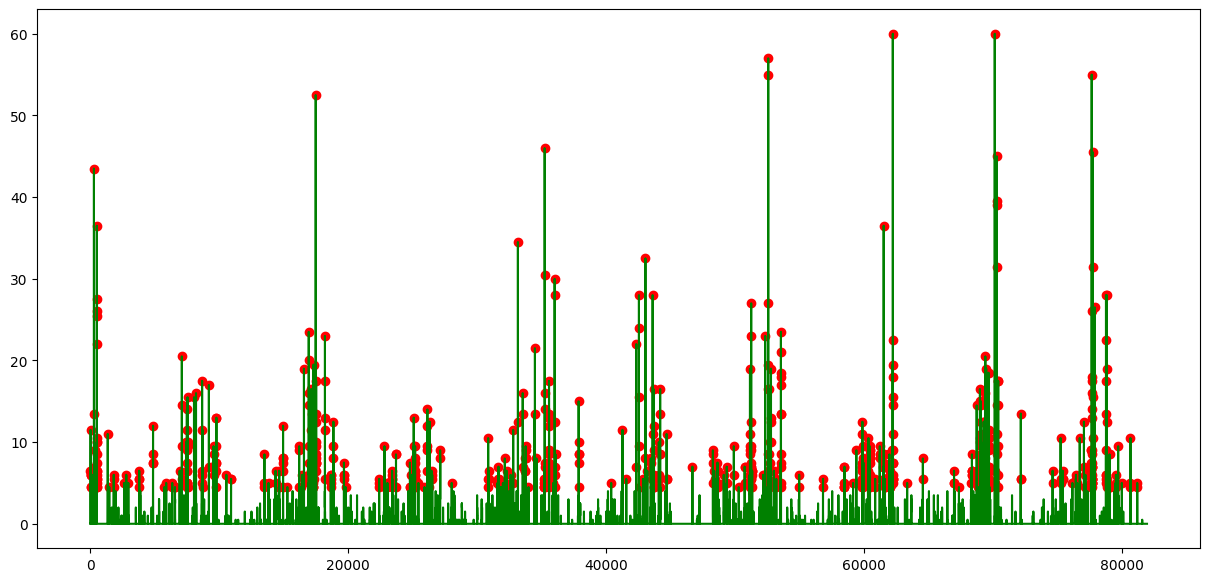

In [122]:
# 함안강수량과 이상치
print("# of Outliers in haman rainfall: ", len(outlier_df["haman"]))
plt.figure(figsize=(15,7))
plt.plot(range(len(rainfall)), rainfall["함안강수량"], color='g')
outlier = rainfall["함안강수량"].iloc[outlier_df['haman']['i']]
plt.scatter(outlier_df["haman"]["i"], outlier, color="r")
# plt.plot(range(len(rainfall)), rainfall["창녕강수량"], color='c' )

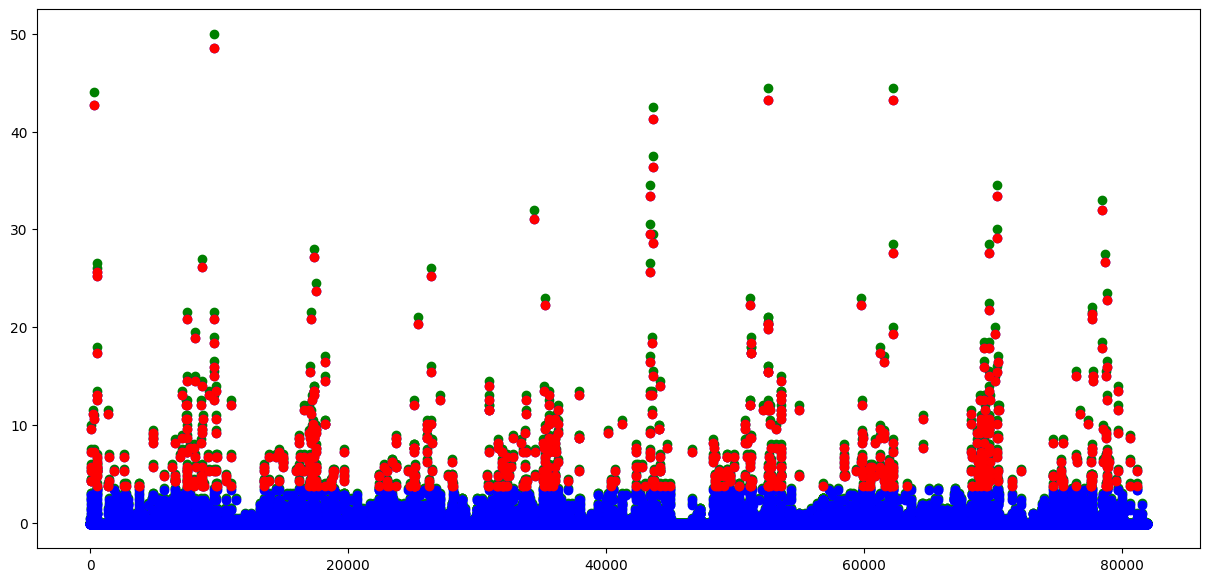

In [123]:
# 창녕강수량과 이상치
outlier_df["chang"] = z_score_outlier_pd(rainfall['창녕강수량'])

# green = raw rainfall value
# blue = z-score
# red = outlier

# of Outliers in haman rainfall:  712


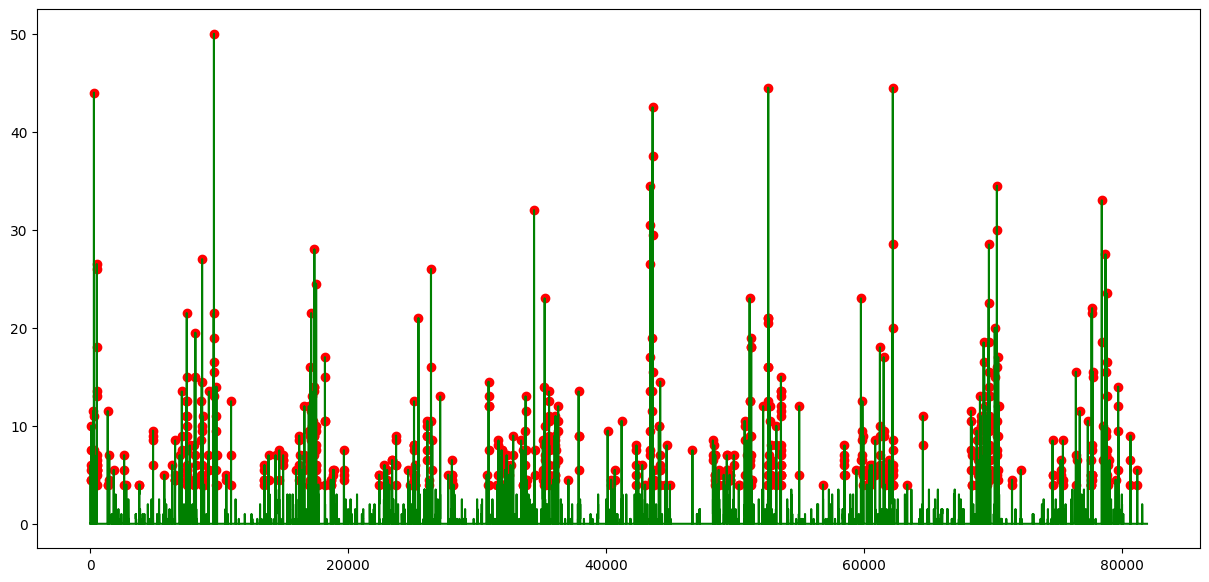

In [124]:
print("# of Outliers in haman rainfall: ", len(outlier_df["haman"]))
plt.figure(figsize=(15,7))
plt.plot(range(len(rainfall)), rainfall["창녕강수량"], color='g')
outlier = rainfall["창녕강수량"].iloc[outlier_df['chang']['i']]
plt.scatter(outlier_df["chang"]["i"], outlier, color="r")
# plt.plot(range(len(rainfall)), rainfall["창녕강수량"], color='c' )

In [189]:
# 보정
modify_cnt = 0
new_Target = Target
for outlier_idx in outlier_df["target"]["i"]:
    if (outlier_idx not in outlier_df["chang"]["i"].values) & (outlier_idx not in outlier_df["haman"]["i"].values):
        new_Target.iloc[outlier_idx] = np.mean([Target.iloc[outlier_idx-1], Target.iloc[outlier_idx+1]])
        modify_cnt += 1
        print("Modified ",outlier_idx,"th value, total: ", modify_cnt)
        print("original: ", Target.iloc[outlier_idx], "; modified: ", new_Target.iloc[outlier_idx])
        print("===========")

C:\Users\mlpa\AppData\Local\Temp\ipykernel_21448\2037772898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Target.iloc[outlier_idx] = np.mean([Target.iloc[outlier_idx-1], Target.iloc[outlier_idx+1]])


Modified  97 th value, total:  1
original:  2710.7995 ; modified:  2710.7995
Modified  98 th value, total:  2
original:  2947.9392500000004 ; modified:  2947.9392500000004
Modified  99 th value, total:  3
original:  3180.4601250000005 ; modified:  3180.4601250000005
Modified  100 th value, total:  4
original:  3396.5885625 ; modified:  3396.5885625
Modified  101 th value, total:  5
original:  3529.1297812499997 ; modified:  3529.1297812499997
Modified  102 th value, total:  6
original:  3631.851390625 ; modified:  3631.851390625
Modified  103 th value, total:  7
original:  3677.2496953125 ; modified:  3677.2496953125
Modified  104 th value, total:  8
original:  3674.81284765625 ; modified:  3674.81284765625
Modified  105 th value, total:  9
original:  3660.909923828125 ; modified:  3660.909923828125
Modified  106 th value, total:  10
original:  3611.781961914063 ; modified:  3611.781961914063
Modified  107 th value, total:  11
original:  3586.898980957031 ; modified:  3586.898980957031

# of Outliers in inflow:  963


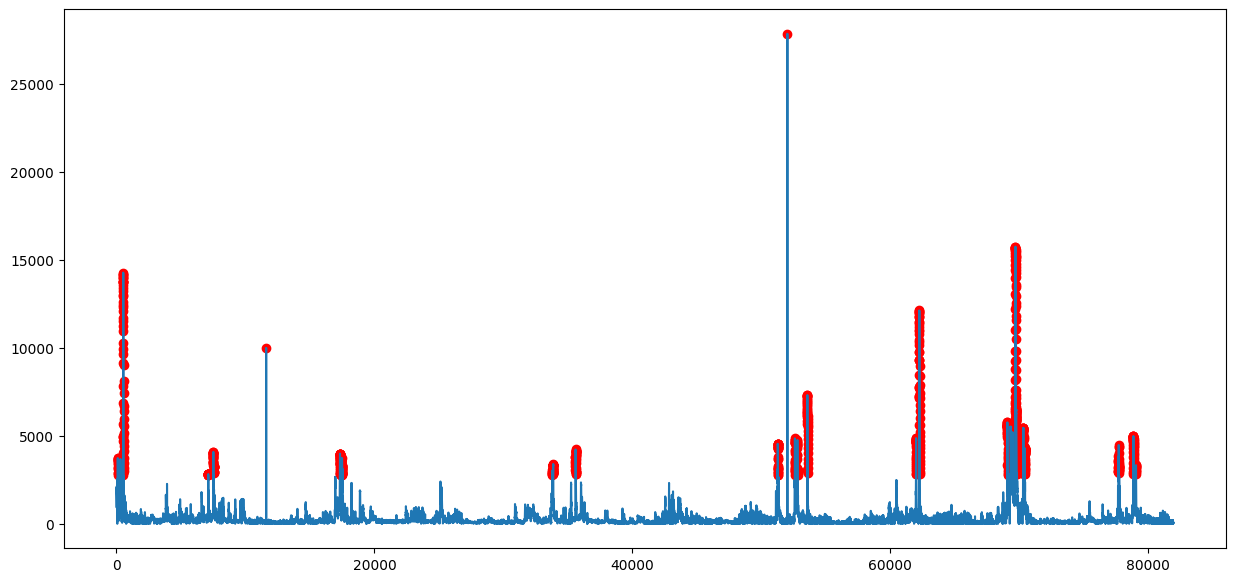

In [131]:
# 원래 유입량
print("# of Outliers in inflow: ", len(outlier_df["target"]))
plt.figure(figsize=(15,7))
plt.plot(range(len(Target)), Target)
outlier = Target.iloc[outlier_df['target']['i']]
plt.scatter(outlier_df['target']["i"], outlier, color='r')

# of Outliers in inflow:  963


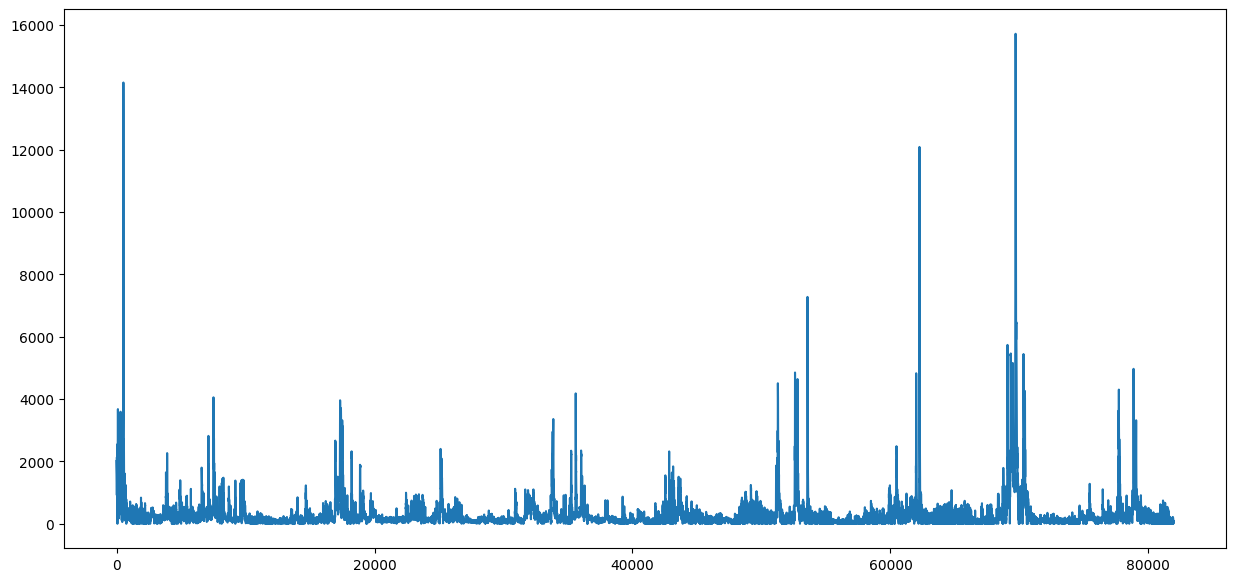

In [190]:
# 수정된 유입량 (이상치는 그대로)
print("# of Outliers in inflow: ", len(outlier_df["target"]))
plt.figure(figsize=(15,7))
plt.plot(range(len(new_Target)), new_Target)
# outlier = Target.iloc[outlier_df['target']['i']]
# plt.scatter(outlier_df['target']["i"], outlier, color='r')

In [193]:
print(new_Target.values)

[2012.95  1985.586 1929.865 ...  110.182   54.676   54.716]


In [194]:
# MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

In [208]:
scaled_Target = new_Target
scaler = MinMaxScaler()
X = scaled_Target.values.reshape(-1, 1)
y = scaler.fit_transform(X)
scaled_Target = pd.Series(y.reshape(-1))

In [209]:
scaled_Target


0        0.128064
1        0.126323
2        0.122778
3        0.122671
4        0.122607
           ...   
81930    0.000000
81931    0.003400
81932    0.007010
81933    0.003478
81934    0.003481
Length: 81935, dtype: float64

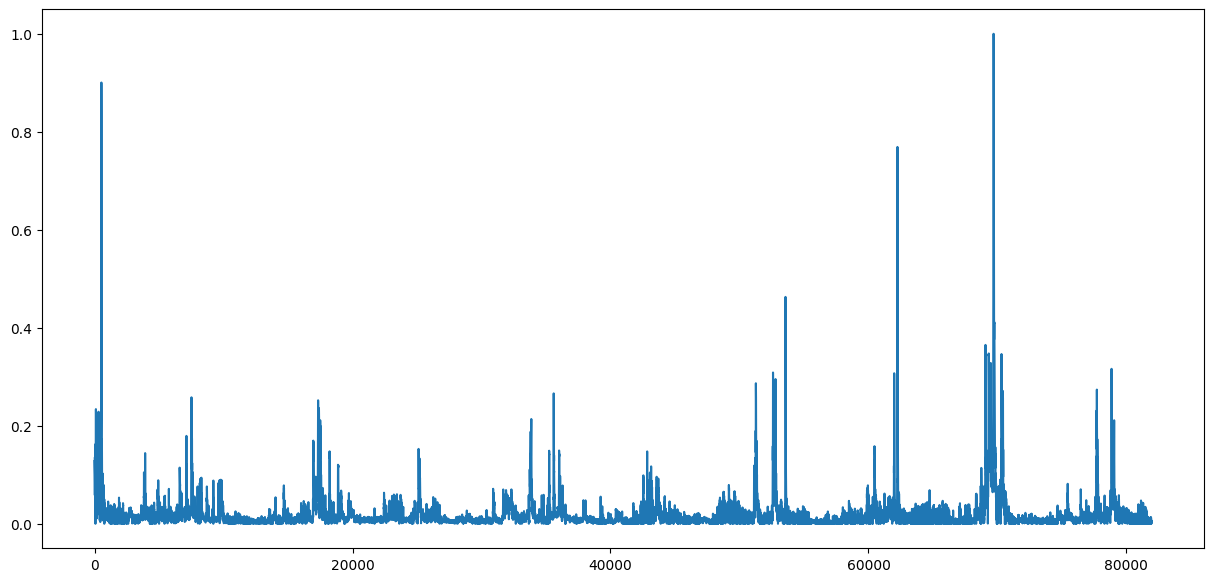

In [210]:
# 스케일링 처리 한 유입량
plt.figure(figsize=(15,7))
plt.plot(range(len(scaled_Target)), scaled_Target)

In [214]:
new_Target.to_csv("./dataset/220928/Target_inflow.csv", index_label=False, index=False)
scaled_Target.to_csv("./dataset/220928/Target_inflow_scaled.csv", index_label=False, index=False)

In [213]:
scaled_Target.shape

(81935,)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(timeline, rainfall["길곡강수량"])